### Data
Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off. This dataset includes 18,000 newsgroups posts with 20 topics.

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

In [5]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

The target attribute is the integer index of the category.

In [7]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [8]:
num_topics, num_top_words = 6, 8

Scikit learn has a method that will extract all the word counts for us.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [10]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [11]:
vocab = np.array(vectorizer.get_feature_names())

In [12]:
vocab.shape

(26576,)

In [13]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

# Singular Value Decomposition (SVD)

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with orthogonal columns and one with orthogonal rows (along with a diagonal matrix, which contains the relative importance of each factor).

SVD is an exact decomposition, since the matrices it creates are big enough to fully cover the original matrix. 

![](https://research.fb.com/wp-content/uploads/2016/11/post00049_image0001.png)

In [14]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 39.3 s, sys: 1.04 s, total: 40.3 s
Wall time: 20.9 s


In [15]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [16]:
# Confirm this is a decomposition of the input.
reconstructed_vectors = U @ np.diag(s) @ Vh
np.allclose(reconstructed_vectors, vectors)

True

In [17]:
# Confirm that U, V are orthonormal
np.allclose(U @ U.T, np.eye(U.shape[0]))

True

In [18]:
np.allclose(U @ U.T, np.eye(U.shape[0]))

True

### Topics
What can we say about the singular values s?

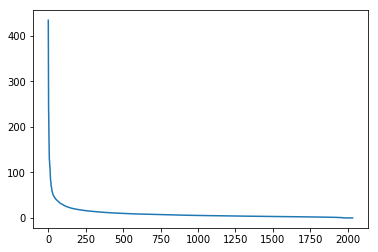

In [19]:
plt.plot(s);

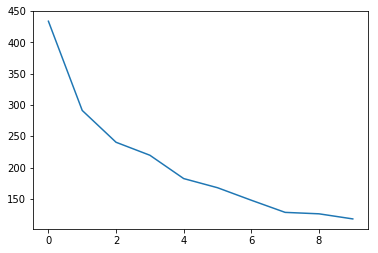

In [20]:
plt.plot(s[:10]);

In [21]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [22]:
show_topics(Vh[:10])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised** algorithm - which is to say, we never actually told the algorithm how our documents are grouped.

For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows.

# Non-negative Matrix Factorization (NMF)

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be non-negative. NMF is a factorization of a non-negative data set $V$:

$V=WH$

into non-negative matrices $W$,$H$. Often positive factors will be more easily interpretable (and this is the reason behind NMF's popularity).

![](https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/images/nmf_doc.png)

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix. NMF is NP-hard and non-unique. There are a number of variations on it, created by adding different constraints.

### NMF from sklearn

In [23]:
m,n=vectors.shape
d=5  # num topics

In [24]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [25]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

Topic Frequency-Inverse Document Frequency (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

* TF = (# occurrences of term t in document) / (# of words in documents)
* IDF = log(# of documents / # documents with term t in it)

In [26]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [27]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [28]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

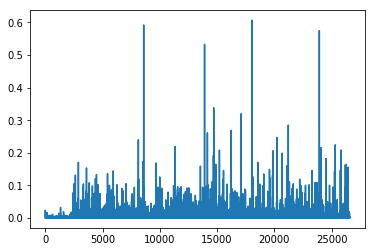

In [29]:
plt.plot(clf.components_[0]);

In [30]:
clf.reconstruction_err_

43.71292605795276

### NMF from scratch in numpy, using SGD

#### Gradient Descent

The key idea of standard gradient descent:

1. Randomly choose some weights to start
2. Loop:
    * Use weights to calculate a prediction
    * Calculate the derivative of the loss
    * Update the weights
3. Repeat step 2 lots of times. Eventually we end up with some decent weights.

**Key**: We want to decrease our loss and the derivative tells us the direction of **steepest descent**.

Note that *loss*, *error*, and *cost* are all terms used to describe the same thing.


In [43]:
from numpy.random import random
from matplotlib import pyplot as plt, rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3
%precision 4
np.set_printoptions(precision=4, linewidth=100)
def lin(a,b,x): return a*x+b

In [32]:
a=3.
b=8.

In [33]:
n=30
x = random(n)
y = lin(a,b,x)

In [34]:
x

array([0.0318, 0.5386, 0.6974, 0.9409, 0.7528, 0.3305, 0.4177, 0.0514, 0.4744, 0.5348, 0.5265,
       0.407 , 0.6915, 0.0314, 0.9704, 0.3792, 0.1883, 0.2844, 0.7163, 0.3532, 0.1518, 0.2569,
       0.2414, 0.0252, 0.4888, 0.2136, 0.3006, 0.8564, 0.4756, 0.9111])

In [35]:
y

array([ 8.0953,  9.6158, 10.0921, 10.8228, 10.2585,  8.9914,  9.253 ,  8.1542,  9.4233,  9.6043,
        9.5796,  9.2211, 10.0744,  8.0942, 10.9111,  9.1375,  8.5649,  8.8532, 10.149 ,  9.0595,
        8.4554,  8.7707,  8.7243,  8.0757,  9.4664,  8.6409,  8.9017, 10.5692,  9.4267, 10.7334])

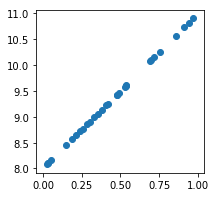

In [36]:
plt.scatter(x,y);

In [37]:
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,a,b,x): return sse(y, lin(a,b,x))
def avg_loss(y,a,b,x): return np.sqrt(loss(y,a,b,x)/n)

In [38]:
a_guess=-1.
b_guess=1.
avg_loss(y, a_guess, b_guess, x)

8.833745746213486

In [39]:
lr=0.01

In [40]:
def upd():
    global a_guess, b_guess
    
    # make a prediction using the current weights
    y_pred = lin(a_guess, b_guess, x)
    
    # calculate the derivate of the loss
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    
    # update our weights by moving in direction of steepest descent
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

In [41]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(10): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 40), interval=100)
ani

#### Stochastic Gradient Descent (SGD)
Stochastic gradient descent is an incredibly useful optimization method (it is also the heart of deep learning, where it is used for backpropagation).

For standard gradient descent, we evaluate the loss using all of our data which can be really slow. In stochastic gradient descent, we evaluate our loss function on just a sample of our data (sometimes called a mini-batch). We would get different loss values on different samples of the data, so this is why it is stochastic. It turns out that this is still an effective way to optimize, and it's much more efficient!

##### Applying SGD to NMF

**Goal**: Decompose $V(m×n)$ into $V≈WH$

where $W(m×d)$ and $H(d×n)$, $W,H>=0$, and we've minimized the Frobenius norm of $V−WH$.

**Approach**: We will pick random positive $W$ & $H$, and then use SGD to optimize.

To use SGD, we need to know the gradient of the loss function.

In [44]:
lam=1e3
lr=1e-2
m, n = vectors_tfidf.shape

In [45]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [46]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [47]:
mu = 1e-6
def grads(M, W, H):
    R = W@H-M
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [48]:
def penalty(M, mu):
    return np.where(M>=mu,0, np.min(M - mu, 0))

In [50]:
def upd(M, W, H, lr):
    dW,dH = grads(M,W,H)
    W -= lr*dW; H -= lr*dH

In [51]:
def report(M,W,H): 
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [52]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [53]:
report(vectors_tfidf, W, H)

44.426800717121075 4.821773415879394e-07 8.290587863967369e-08 0 0


In [54]:
upd(vectors_tfidf,W,H,lr)

In [55]:
report(vectors_tfidf, W, H)

44.41898441472066 -0.0008849482423339409 -8.816284644794796e-05 138 284


In [56]:
for i in range(50): 
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf,W,H)

44.41333510787703 -0.0007814340301332738 -7.243928762946151e-05 146 271
44.37534134985301 -0.0004805841555981169 -5.277406121604748e-05 57 518
44.34675606899547 -0.00018300161803994167 -5.677897150890787e-05 23 961
44.314850550765584 -0.00014371756573821527 -9.250648842341036e-05 23 1556
44.27969392304737 -0.00012632967050584356 -0.00011022328196614114 26 2196


In [57]:
show_topics(H)

['people just god space don like know does',
 'god people don know just space does like',
 'space think people don god like just know',
 'space don god people like just know think',
 'just god space don people like think know']

This is painfully slow to train! Lots of parameter fiddling and still slow to train (or explodes).

# PyTorch

In [58]:
import torch
import torch.cuda as tc
from torch.autograd import Variable

In [60]:
def V(M): return Variable(M, requires_grad=True)

In [61]:
v=vectors_tfidf.todense()

In [67]:
t_vectors = torch.Tensor(v.astype(np.float32))#.cuda()

In [68]:
mu = 1e-5

In [74]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam, 
        W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(torch.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH)

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [75]:
t_W = torch.FloatTensor(m,d)
t_H = torch.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); 
t_H.normal_(std=0.01).abs_();

In [76]:
d=6; lam=100; lr=0.05

In [77]:
for i in range(1000): 
    upd_t(t_vectors,t_W,t_H,lr)
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9

tensor(44.3939) tensor(-0.0062) tensor(-0.0005) tensor(1478) tensor(2173)
tensor(43.7057) tensor(-0.0099) tensor(-0.0177) tensor(1826) tensor(20545)
tensor(43.6714) tensor(-0.0078) tensor(-0.0037) tensor(2209) tensor(22760)
tensor(43.6627) tensor(-0.0050) tensor(-0.0057) tensor(2374) tensor(23027)
tensor(43.6601) tensor(-0.0065) tensor(-0.0101) tensor(2512) tensor(22960)
tensor(43.6585) tensor(-0.0040) tensor(-0.0064) tensor(3000) tensor(24393)
tensor(43.6571) tensor(-0.0055) tensor(-0.0046) tensor(3109) tensor(25248)
tensor(43.6562) tensor(-0.0044) tensor(-0.0028) tensor(2930) tensor(26141)
tensor(43.6556) tensor(-0.0046) tensor(-0.0042) tensor(2836) tensor(26143)
tensor(43.6550) tensor(-0.0040) tensor(-0.0040) tensor(3329) tensor(31798)


In [79]:
show_topics(t_H.cpu().numpy())

['thanks files file image program format know windows',
 'god jesus bible believe christian atheism belief does',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'graphics software comp 3d group mac amiga edu',
 'people don think just objective like say morality',
 'space nasa launch shuttle orbit moon lunar earth']

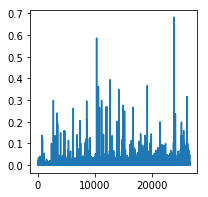

In [81]:
plt.plot(t_H.cpu().numpy()[0]);

In [82]:
t_W.mm(t_H).max()

tensor(0.3990)

In [83]:
t_vectors.max()

tensor(1.)

## PyTorch: autograd

PyTorch has an automatic differentiation package, autograd. This is really useful, in that we can use autograd on problems where we don't know what the derivative is.

In PyTorch, Variables have the same API as tensors, but Variables remember the operations used on to create them. This lets us take derivatives.

### PyTorch Autograd Introduction

In [84]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [85]:
print(x.data)

tensor([[1., 1.],
        [1., 1.]])


In [86]:
print(x.grad)

None


In [87]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [88]:
z = y * y * 3
out = z.sum()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(108., grad_fn=<SumBackward0>)


In [89]:
out.backward()
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])


### Using Autograd for NMF

In [90]:
lam=1e6

In [91]:
pW = Variable(torch.FloatTensor(m,d), requires_grad=True)
pH = Variable(torch.FloatTensor(d,n), requires_grad=True)
pW.data.normal_(std=0.01).abs_()
pH.data.normal_(std=0.01).abs_();

In [95]:
def report():
    W,H = pW.data, pH.data
    print((M-pW.mm(pH)).norm(2).item(), W.min(), H.min(), (W<0).sum(), (H<0).sum())

def penalty(A):
    return torch.pow((A<0).type(torch.FloatTensor)*torch.clamp(A, max=0.), 2)

def penalize(): return penalty(pW).mean() + penalty(pH).mean()

def loss(): return (M-pW.mm(pH)).norm(2) + penalize()*lam

In [96]:
M = Variable(t_vectors)

In [97]:
opt = torch.optim.Adam([pW,pH], lr=1e-3, betas=(0.9,0.9))
lr = 0.05
report()

44.43931579589844 tensor(1.4027e-06) tensor(3.0473e-08) tensor(0) tensor(0)


How to apply SGD, using autograd:

In [98]:
for i in range(1000): 
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    if i % 100 == 99: 
        report()
        lr *= 0.9     # learning rate annealling

43.972007751464844 tensor(-0.0010) tensor(-0.0013) tensor(245) tensor(11849)
43.79525375366211 tensor(-0.0009) tensor(-0.0019) tensor(289) tensor(13892)
43.730712890625 tensor(-0.0008) tensor(-0.0009) tensor(221) tensor(14412)
43.697654724121094 tensor(-0.0006) tensor(-0.0012) tensor(212) tensor(14422)
43.679866790771484 tensor(-0.0003) tensor(-0.0013) tensor(194) tensor(13132)
43.67197036743164 tensor(-0.0003) tensor(-0.0012) tensor(207) tensor(12004)
43.66824722290039 tensor(-0.0003) tensor(-0.0011) tensor(199) tensor(11009)
43.666282653808594 tensor(-0.0003) tensor(-0.0013) tensor(266) tensor(10248)
43.66117477416992 tensor(-0.0003) tensor(-0.0012) tensor(242) tensor(10045)
43.6561164855957 tensor(-0.0004) tensor(-0.0010) tensor(265) tensor(9804)


In [100]:
h = pH.data.cpu().numpy()
show_topics(h)

['just don think graphics like people know ve',
 'god jesus bible believe christian atheism does belief',
 'space nasa launch shuttle orbit lunar moon earth',
 'ico bobbe tek bronx beauchaine manhattan sank queens',
 'objective morality values moral subjective science absolute people',
 'thanks files image file program graphics windows format']

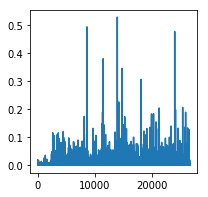

In [101]:
plt.plot(h[0]);

# Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD. We are just interested in the vectors corresponding to the **largest** singular values.

**Shortcomings of classical algorithms for decomposition:**
* Matrices are "stupendously big"
* Data are often **missing or inaccurate**. Why spend extra computational resources when imprecision of input limits precision of the output?
* **Data transfer** now plays a major role in time of algorithms. Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
* Important to take advantage of GPUs.

**Advantages of randomized algorithms:**
* inherently stable
* performance guarantees do not depend on subtle spectral properties
* needed matrix-vector products can be done in parallel

### Randomized SVD
Reminder: full SVD is slow. This is the calculation we did above using Scipy's Linalg SVD:

In [99]:
vectors.shape

(2034, 26576)

In [102]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 43.7 s, sys: 1.76 s, total: 45.5 s
Wall time: 24.9 s


In [103]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Fortunately, there is a faster way:

**Question**: How can we speed things up? (without new breakthroughs in SVD research)

**Idea**: Let's use a smaller matrix (with smaller $n$)!

Instead of calculating the SVD on our full matrix A which is $m×n$, let's use $B=AQ$, which is just $m×r$ and $r<<n$

We haven't found a better general SVD method, we are just using the method we have on a smaller matrix.

In [104]:
%time u, s, v = decomposition.randomized_svd(vectors, 5)

CPU times: user 8.56 s, sys: 3.38 s, total: 11.9 s
Wall time: 7.72 s


In [105]:
print(u.shape, s.shape, v.shape)

(2034, 5) (5,) (5, 26576)


In [106]:
show_topics(v)

['jpeg image edu file graphics images gif data',
 'jpeg gif file color quality image jfif format',
 'space jesus launch god people satellite matthew atheists',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']